In [ ]:
import os 
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize 

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint
from torchvision.io import read_image


import torchvision
import torchvision.transforms.v2 as v2

from PIL import Image


from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform,utils
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead



%matplotlib inline

In [ ]:
num_workers = 0
batch_size = 256
seed = 42
max_epochs = 20
input_size = 128

In [3]:
pl.seed_everything(seed)

Seed set to 42


42

In [ ]:
class CustomSimCLRTransform:
    def __init__(self, input_size=224):
        self.transform = v2.Compose([
            v2.RandomResizedCrop(size=(input_size, input_size), scale=(0.6, 1.0)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=15),
            v2.RandomApply([v2.Grayscale(num_output_channels=3)], p=0.4),  
            v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.2),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
    def __call__(self, x):
        return self.transform(x), self.transform(x)


In [ ]:
#transform=SimCLRTransform(input_size=input_size,vf_prob=0.5,rr_prob=0.5,)

transform=CustomSimCLRTransform(input_size=input_size)
test_transform=torchvision.transforms.v2.Compose([
    v2.Resize((input_size, input_size)),
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    )
]
)

dataset_train_simclr=LightlyDataset(input_dir='clothing-dataset-master/images',transform=transform)

dataset_test=LightlyDataset(input_dir='clothing-dataset-master/images',transform=test_transform)

dataloader_train_simclr= torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

dataloader_test= torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=True,
)

In [ ]:
resnet=torchvision.models.resnet18()
m=nn.Sequential(*list(resnet.children())[:-1])
print(m)
print('-----------------------------')
hidden_dim=resnet.fc.in_features
print(hidden_dim)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [9]:

class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        resnet=torchvision.models.resnet18()
        self.backbone=nn.Sequential(*list(resnet.children())[:-1])
        
        hidden_dim=resnet.fc.in_features

        self.projection_head=SimCLRProjectionHead(hidden_dim,hidden_dim,128)

        self.criterion=NTXentLoss()

    def forward(self,x):
        z=self.backbone(x).flatten(start_dim=1)
        z=self.projection_head(z)
        return z
    
    def training_step(self,batch,batch_idx):
        (x0,x1),_,_=batch
        z0=self.forward(x0)
        z1=self.forward(x1)
        loss =self.criterion(z0,z1)
        self.log('train_loss',loss)
        return loss
    
    def configure_optimizers(self):
        optim =torch.optim.SGD(self.parameters(),lr=6e-2,momentum=0.9,weight_decay=5e-4)
        scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optim,T_max=max_epochs)
        return [optim],[scheduler]

In [10]:
model=SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1,accelerator='gpu')
trainer.fit(model,dataloader_train_simclr)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\DELL\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precisi

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
def genrerate_embeddings(model,dataloader):

    embeddings= []
    filenames=[]
    with torch.no_grad():
        for img,_,fnames in dataloader:
            img=img.to(model.device)
            emb=model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings=torch.cat(embeddings,dim=0)
    embeddings=normalize(embeddings)
    return embeddings,filenames

model.eval()
embedding,filenames=genrerate_embeddings(model,dataloader_test)


In [13]:
def get_image_as_numpy(filename: str):
    img = Image.open(filename)
    return np.asarray(img)

def plot_knn_examples(embedding, filenames, n_neighbors=3, n_examples=3):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embedding)
    distances, indices = nbrs.kneighbors(embedding)
    sample_idx = np.random.choice(len(embedding), n_examples, replace=False)

    for idx in sample_idx:
        fig = plt.figure(figsize=(12, 4))

        ax = fig.add_subplot(1, n_neighbors + 1, 1)
        query_path = os.path.join('clothing-dataset-master/images', filenames[idx])
        plt.imshow(get_image_as_numpy(query_path))
        ax.set_title("Query")
        plt.axis("off")

        for i, neighbor_idx in enumerate(indices[idx][1:], start=2):  # skip self
            ax = fig.add_subplot(1, n_neighbors + 1, i)
            neighbor_path = os.path.join('clothing-dataset-master/images', filenames[neighbor_idx])
            plt.imshow(get_image_as_numpy(neighbor_path))
            ax.set_title(f"Neighbor {i-1}")
            plt.axis("off")

        plt.show()

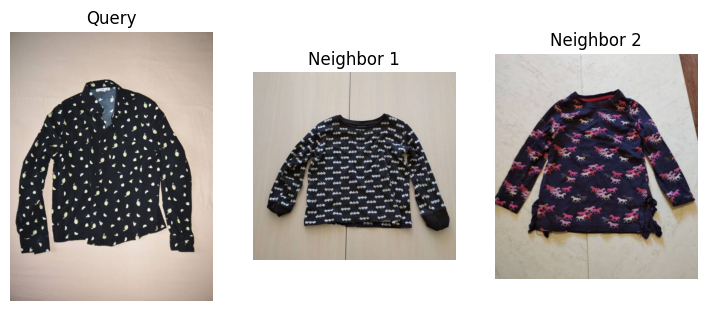

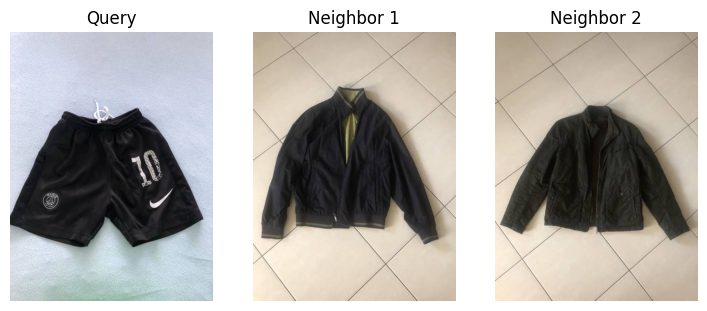

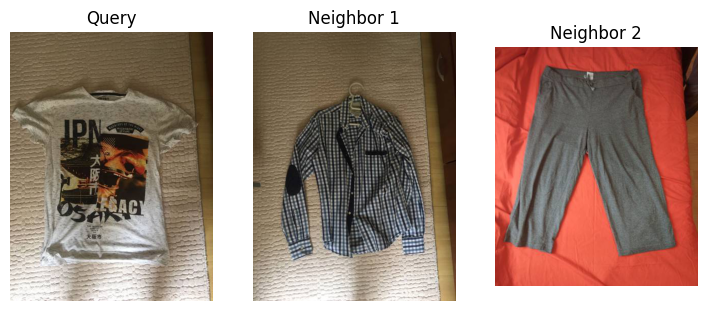

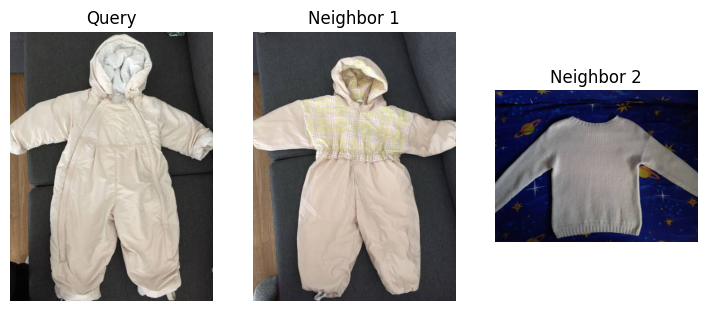

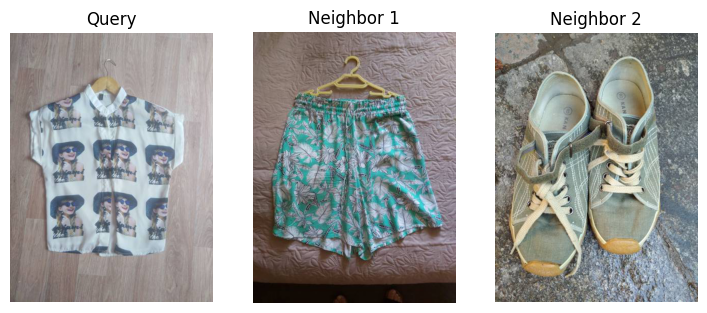

In [16]:
plot_knn_examples(embedding,filenames,3,5)

In [ ]:
df = pd.read_csv("clothing-dataset-master/images.csv")
unlabeled = df[df['label'].isin(['Not sure', 'Other', 'skip'])]
print(len(unlabeled))
df=df.drop(unlabeled.index)
classes_names=df['label'].unique()
num_classes=len(classes_names)
print(classes_names)
print(num_classes)
df=df.reset_index(drop=True)

295
['T-Shirt' 'Shoes' 'Shorts' 'Shirt' 'Pants' 'Skirt' 'Top' 'Outwear'
 'Dress' 'Body' 'Longsleeve' 'Undershirt' 'Hat' 'Polo' 'Blouse' 'Hoodie'
 'Skip' 'Blazer']
18


In [133]:
for i in df['image'].values:
    if not os.path.exists(f'clothing-dataset-master/images/{i}.jpg'):
        print(i)
        df=df.drop(df[df['image']==i].index)
df=df.reset_index(drop=True)

d028580f-9a98-4fb5-a6c9-5dc362ad3f09
1d0129a1-f29a-4a3f-b103-f651176183eb
784d67d4-b95e-4abb-baf7-8024f18dc3c8
c60e486d-10ed-4f64-abab-5bb698c736dd
040d73b7-21b5-4cf2-84fc-e1a80231b202


In [158]:
backbone = model.backbone
backbone.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [179]:
class FineTuneModel(pl.LightningModule):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone

        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in list(self.backbone.parameters())[-20:]:
            param.requires_grad = True

        self.classifier = nn.Linear(512, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        feats = self.backbone(x).flatten(start_dim=1)
        logits = self.classifier(feats)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        params = list(self.classifier.parameters()) + list(self.backbone.parameters())[-20:]
        return torch.optim.Adam(params, lr=5e-4, weight_decay=1e-4)

In [181]:
class SimpleTransform:
    def __init__(self, input_size=128):
        self.transform = v2.Compose([
            v2.Resize((input_size, input_size)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        return self.transform(x)


In [182]:
class CustomFineTuneDataset(Dataset):
    def __init__(self, DataFrame, img_dir, transform=None):
        self.data = DataFrame
        self.img_dir = img_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(self.data['label'].unique())}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0])
        img_path = f"{self.img_dir}/{img_name}.jpg"

        image = read_image(img_path).float() / 255.0
        label_str = self.data.iloc[idx, 2]
        label = torch.tensor(self.label_to_idx[label_str], dtype=torch.long)

        if self.transform:
            image = self.transform(image)
        return image, label


In [183]:
simple_transform = SimpleTransform(input_size=128)
dataset = CustomFineTuneDataset(df, img_dir="clothing-dataset-master/images", transform=simple_transform)
dataloader_tuning = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [184]:

checkpoint_callback = ModelCheckpoint(
    monitor="train_acc",
    mode="max",
    filename="best-model-{epoch:02d}-{train_acc:.2f}",
    save_top_k=1,
    save_weights_only=True
)

progress_bar = TQDMProgressBar(refresh_rate=20)

finetune_model = FineTuneModel(backbone, num_classes=num_classes)
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    callbacks=[progress_bar, checkpoint_callback],
    log_every_n_steps=5
)

trainer.fit(finetune_model, dataloader_tuning)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | backbone   | Sequential       | 11.2 M | eval 
1 | classifier | Linear           | 9.2 K  | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
9.0 M     Trainable params
2.2 M     Non-trainable params
11.2 M    Total params
44.743    Total estimated model params size (MB)
2         Modules in train mode
67        Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



Accuracy: 0.9939
Precision: 0.9940
Recall: 0.9939
F1 Score: 0.9939

Classification Report:
              precision    recall  f1-score   support

     T-Shirt       1.00      1.00      1.00      1011
       Shoes       0.99      1.00      1.00       431
      Shorts       0.99      0.99      0.99       308
       Shirt       0.99      0.99      0.99       378
       Pants       1.00      1.00      1.00       692
       Skirt       1.00      0.99      0.99       155
         Top       0.95      0.98      0.97        43
     Outwear       0.99      0.98      0.98       312
       Dress       0.99      1.00      1.00       357
        Body       1.00      1.00      1.00        69
  Longsleeve       0.99      1.00      1.00       699
  Undershirt       1.00      0.97      0.99       118
         Hat       0.99      1.00      0.99       171
        Polo       1.00      1.00      1.00       120
      Blouse       1.00      0.96      0.98        23
      Hoodie       0.94      0.99      0.97

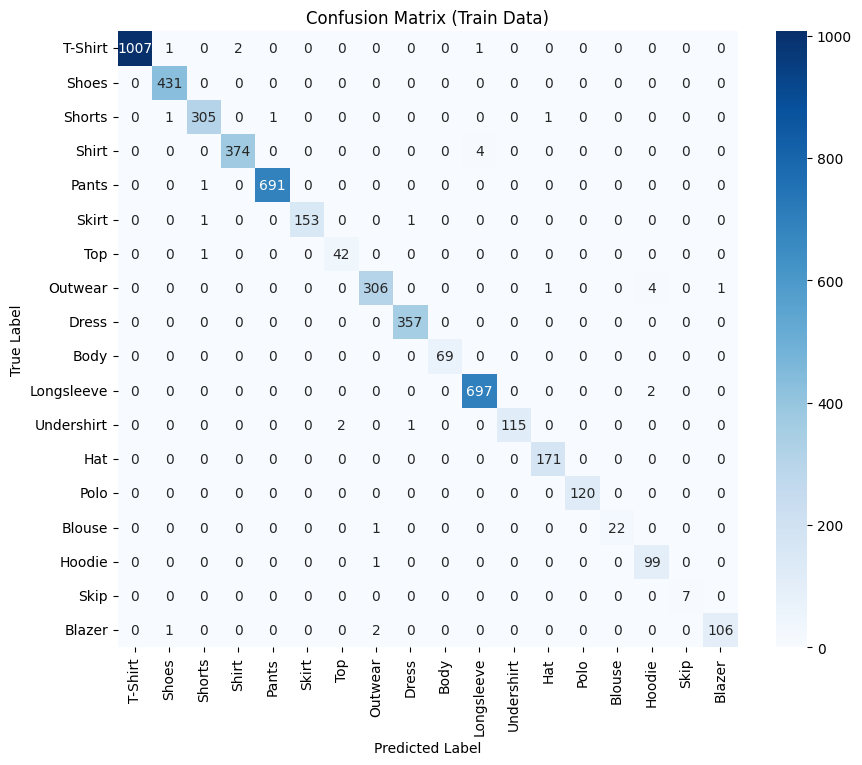

In [ ]:
finetune_model.eval()
finetune_model.to("cuda")

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in dataloader_tuning:   
        x, y = x.to("cuda"), y.to("cuda")

        outputs = finetune_model(x)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, zero_division=0, target_names=classes_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Train Data)")
plt.show()

In [170]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # 128x128 input → بعد 3 pooling layers يصبح 16x16
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.4)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 16, 16]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x,y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)


In [171]:
cnn_model = SimpleCNN(num_classes=num_classes)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10
)

trainer.fit(cnn_model, dataloader_tuning)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 896    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | pool      | MaxPool2d        | 0      | train
3 | conv3     | Conv2d           | 73.9 K | train
4 | fc1       | Linear           | 8.4 M  | train
5 | fc2       | Linear           | 4.6 K  | train
6 | dropout   | Dropout          | 0      | train
7 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



Accuracy: 0.9904
Precision: 0.9905
Recall: 0.9904
F1 Score: 0.9904

Classification Report:
              precision    recall  f1-score   support

     T-Shirt       0.99      1.00      0.99      1011
       Shoes       1.00      1.00      1.00       431
      Shorts       0.98      1.00      0.99       308
       Shirt       0.99      0.99      0.99       378
       Pants       1.00      1.00      1.00       692
       Skirt       0.98      0.98      0.98       155
         Top       0.98      1.00      0.99        43
     Outwear       0.98      0.97      0.98       312
       Dress       0.99      0.98      0.99       357
        Body       1.00      1.00      1.00        69
  Longsleeve       0.99      0.99      0.99       699
  Undershirt       0.99      0.97      0.98       118
         Hat       0.99      1.00      1.00       171
        Polo       0.98      1.00      0.99       120
      Blouse       1.00      0.91      0.95        23
      Hoodie       0.99      0.98      0.98

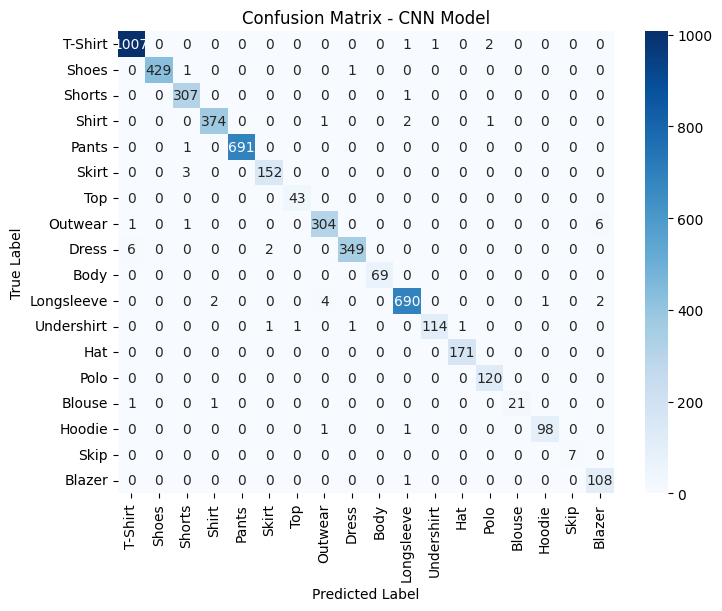

In [172]:
cnn_model.eval()
cnn_model.to("cuda")

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in dataloader_tuning:
        x, y = x.to("cuda"), y.to("cuda")
        outputs = cnn_model(x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())



acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, zero_division=0, target_names=classes_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN Model")
plt.show()


In [ ]:
torch.save(finetune_model.state_dict(), "finetune_model.pth")

In [ ]:
import torchvision.transforms as T
test_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

def predict_image(image_path,model):
    img = Image.open(image_path).convert("RGB")
    img_tensor = test_transform(img).unsqueeze(0).to("cuda")

    with torch.no_grad():
        outputs = model(img_tensor)
        pred = torch.argmax(outputs, dim=1).item()
    
    predicted_label = classes_names[pred]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    print(f"✅ Prediction: {predicted_label}")

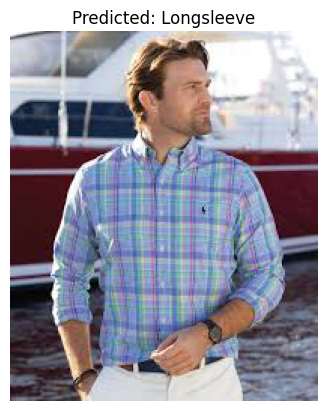

✅ Prediction: Longsleeve


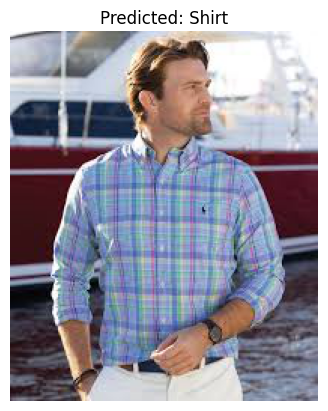

✅ Prediction: Shirt


In [234]:
i=8
format="jpg"
predict_image(f"D:/projects/constractive_learing2/test{i}.{format}", finetune_model)
predict_image(f"D:/projects/constractive_learing2/test{i}.{format}", cnn_model)